# 🎨 범용 동화 표지 이미지 생성기
## Imagen 4.0 Fast - 텍스트 완전 제거 버전

**특징:**
- ✅ 어떤 동화 JSON이든 자동 분석
- ✅ 텍스트 완전 제거 (깔끔한 일러스트만)
- ✅ 아동용 동화 표지 스타일 강조
- ✅ W:149 × H:120 크기 자동 생성

**사용 방법:**
1. 동화 JSON 업로드
2. Gemini API 키 입력
3. 자동 표지 생성
4. 다운로드

## 1단계: 라이브러리 설치

In [23]:
!pip install google-generativeai pillow -q

import json
import os
from getpass import getpass
import google.generativeai as genai
from PIL import Image
import io
from google.colab import files

print("✅ 라이브러리 설치 완료")

✅ 라이브러리 설치 완료


## 2단계: Gemini API 설정

In [24]:
# Gemini API 키 입력
GEMINI_API_KEY = getpass("Gemini API Key (AI...): ")
genai.configure(api_key=GEMINI_API_KEY)

print("✅ Gemini API 설정 완료")

Gemini API Key (AI...): ··········
✅ Gemini API 설정 완료


## 3단계: 동화 JSON 업로드

In [25]:
# JSON 파일 업로드
print("📂 동화 JSON 파일을 업로드하세요:")
uploaded = files.upload()

# 업로드된 파일 이름 가져오기
json_filename = list(uploaded.keys())[0]
print(f"\n✅ 업로드 완료: {json_filename}")

# JSON 파일 읽기
with open(json_filename, 'r', encoding='utf-8') as f:
    story_data = json.load(f)

# 동화 정보 출력
print("\n📖 동화 정보:")
print(f"제목: {story_data['story_info']['title']}")
if 'theme' in story_data['story_info']:
    print(f"테마: {story_data['story_info']['theme']}")
print(f"키워드: {', '.join(story_data['story_info']['keywords'])}")
print(f"줄거리: {story_data['story_info']['summary'][:100]}...")

📂 동화 JSON 파일을 업로드하세요:


Saving 잠꾸러기_지호_20251212_1730.json to 잠꾸러기_지호_20251212_1730 (2).json

✅ 업로드 완료: 잠꾸러기_지호_20251212_1730 (2).json

📖 동화 정보:
제목: 잠꾸러기 지호
테마: 재미
키워드: 김밥 도시락, 학교 운동장, 전자시계
줄거리: 잠꾸러기 지호는 매일 아침 학교에 지각을 하고, 수업시간에는 꾸벅꾸벅 졸기 일쑤입니다. 어느 날, 지호는 학교에서 전자시계를 잃어버리고, 친구 수미가 선물한 행운의 열쇠고리를 발견...


## 4단계: 범용 표지 생성 함수

In [44]:
# ============================================================
# 동화 내용 기반 동적 프롬프트 생성
# 한복 강제 X, 동화 스토리에 맞는 자연스러운 표현
# ============================================================

def analyze_story_for_image_enhanced(story_data):
    """
    동화 내용을 깊이 분석하여 이미지 생성 정보 추출
    - 주인공 외형/의상 파악
    - 핵심 장소/배경 추출
    - 분위기/감정 분석
    - 중요 소품/오브젝트 파악
    """
    keywords = story_data['story_info'].get('keywords', [])
    content = story_data.get('content', '')
    summary = story_data['story_info'].get('summary', '')

    # 전체 텍스트
    full_text = f"{summary} {content}"

    # ==================== 1. 주인공 분석 ====================
    character_desc = "a young Korean child"

    # 성별 파악
    if '소녀' in full_text or '여자' in full_text or '공주' in full_text:
        character_desc = "a young Korean girl"
    elif '소년' in full_text or '남자' in full_text or '왕자' in full_text:
        character_desc = "a young Korean boy"

    # 나이대 파악
    age_desc = ""
    if '유치원' in full_text or '어린이집' in full_text:
        age_desc = "preschool age (4-6 years old)"
    elif '초등학생' in full_text or '학교' in full_text:
        age_desc = "elementary school age (7-9 years old)"

    # ==================== 2. 의상/외형 분석 ====================
    clothing_desc = ""

    # 명시적 의상 언급 확인
    clothing_keywords = {
        '한복': 'wearing colorful traditional Korean hanbok',
        '교복': 'wearing school uniform',
        '잠옷': 'wearing cozy pajamas',
        '운동복': 'wearing comfortable sportswear',
        '원피스': 'wearing a pretty dress',
        '티셔츠': 'wearing casual t-shirt and pants',
    }

    for keyword, desc in clothing_keywords.items():
        if keyword in full_text:
            clothing_desc = desc
            break

    # 의상 언급 없으면 상황에 맞게 자동 결정
    if not clothing_desc:
        if '학교' in full_text or '수업' in full_text:
            clothing_desc = 'wearing casual school clothes'
        elif '잠' in full_text or '꿈' in full_text or '밤' in full_text:
            clothing_desc = 'wearing comfortable sleepwear'
        elif '놀이터' in full_text or '운동장' in full_text:
            clothing_desc = 'wearing playful casual clothes'
        elif '조선' in full_text or '옛날' in full_text or '전통' in full_text:
            clothing_desc = 'wearing traditional Korean hanbok'
        else:
            clothing_desc = 'wearing comfortable everyday clothes'

    # ==================== 3. 배경/장소 분석 ====================
    setting_elements = []

    location_keywords = {
        '학교': 'school environment with classroom elements',
        '운동장': 'school playground with play equipment',
        '교실': 'bright classroom setting',
        '놀이터': 'colorful playground',
        '집': 'cozy home interior',
        '방': 'child\'s bedroom',
        '부엌': 'warm kitchen',
        '공원': 'beautiful park with trees',
        '숲': 'enchanted forest',
        '산': 'Korean mountain landscape',
        '강': 'peaceful riverside',
        '바다': 'seaside scenery',
        '마을': 'Korean village',
        '도시': 'modern city',
        '궁': 'traditional Korean palace',
        '한옥': 'traditional Korean house',
    }

    for keyword, desc in location_keywords.items():
        if keyword in full_text or keyword in keywords:
            setting_elements.append(desc)

    # 기본 배경 (아무것도 없으면)
    if not setting_elements:
        setting_elements = ['soft dreamy background']

    # ==================== 4. 시간대/분위기 ====================
    time_of_day = ""

    if '아침' in full_text:
        time_of_day = "bright morning atmosphere with warm sunlight"
    elif '낮' in full_text or '점심' in full_text:
        time_of_day = "cheerful daytime with clear bright light"
    elif '저녁' in full_text or '해질녘' in full_text:
        time_of_day = "warm evening with golden hour lighting"
    elif '밤' in full_text or '달' in full_text:
        time_of_day = "gentle nighttime with soft moonlight"

    # ==================== 5. 감정/분위기 ====================
    mood = "heartwarming and magical"

    if '모험' in full_text or '탐험' in full_text:
        mood = "adventurous and exciting"
    elif '신비' in full_text or '마법' in full_text:
        mood = "mystical and enchanting"
    elif '따뜻' in full_text or '사랑' in full_text or '우정' in full_text:
        mood = "warm and touching"
    elif '재미' in full_text or '웃음' in full_text:
        mood = "fun and joyful"
    elif '용기' in full_text or '도전' in full_text:
        mood = "brave and inspiring"
    elif '슬픔' in full_text or '외로' in full_text:
        mood = "gentle and comforting"

    # ==================== 6. 중요 소품/오브젝트 ====================
    key_objects = []

    object_keywords = {
        '책': 'books',
        '시계': 'clock',
        '가방': 'backpack',
        '도시락': 'lunchbox',
        '우산': 'umbrella',
        '꽃': 'flowers',
        '나무': 'trees',
        '별': 'stars',
        '구름': 'clouds',
        '새': 'birds',
        '나비': 'butterflies',
        '공': 'ball',
        '인형': 'doll',
        '악기': 'musical instrument',
    }

    for keyword, obj in object_keywords.items():
        if keyword in full_text:
            key_objects.append(obj)

    # ==================== 7. 한국 문화 요소 ====================
    korean_elements = []

    korean_items = {
        '한복': 'traditional Korean hanbok',
        '떡': 'Korean rice cakes',
        '한옥': 'traditional Korean architecture',
        '궁': 'palace architecture',
        '산': 'Korean mountains',
        '강': 'Korean river',
        '전통': 'traditional Korean patterns',
        '등': 'traditional Korean lanterns',
        '부채': 'traditional Korean fan',
    }

    for keyword, element in korean_items.items():
        if keyword in full_text:
            korean_elements.append(element)

    return {
        'character': character_desc,
        'age': age_desc,
        'clothing': clothing_desc,
        'setting_elements': setting_elements[:3],  # 최대 3개
        'time_of_day': time_of_day,
        'mood': mood,
        'key_objects': key_objects[:3],  # 최대 3개
        'korean_elements': korean_elements[:2],  # 최대 2개
    }


def create_dynamic_image_prompt_v2(analysis):
    """
    동화 내용 기반 완전 동적 프롬프트 생성
    한복 강제 X, 스토리에 맞게 자연스럽게
    """

    # 캐릭터 설명
    character_full = f"{analysis['character']}"
    if analysis['age']:
        character_full += f", {analysis['age']}"
    if analysis['clothing']:
        character_full += f", {analysis['clothing']}"

    # 배경 요소 조합
    setting_text = " and ".join(analysis['setting_elements'])

    # 시간대 추가
    if analysis['time_of_day']:
        setting_text += f", {analysis['time_of_day']}"

    # 주요 오브젝트
    objects_text = ""
    if analysis['key_objects']:
        objects_text = f"Include {', '.join(analysis['key_objects'])} as natural elements in the scene."

    # 한국 문화 요소 (있으면 자연스럽게 추가)
    korean_text = ""
    if analysis['korean_elements']:
        korean_text = f"Subtle Korean cultural elements: {', '.join(analysis['korean_elements'])}."

    # 분위기별 색상
    mood_colors = {
        'adventurous and exciting': 'vibrant warm colors with dynamic energy',
        'mystical and enchanting': 'soft purple, blue, and golden magical tones',
        'warm and touching': 'warm pastel colors with gentle pink and orange',
        'heartwarming and magical': 'soft warm pastel colors with gentle glow',
        'fun and joyful': 'bright cheerful colors with playful energy',
        'brave and inspiring': 'strong confident colors with warm highlights',
        'gentle and comforting': 'soft soothing colors with gentle warmth',
    }

    color_palette = mood_colors.get(analysis['mood'], 'warm soft colors')

    # 최종 프롬프트
    prompt = f"""
NO TEXT. NO Korean hangul (한글). NO English (ABC). Pure illustration only.

A beautiful watercolor illustration painting for a children's storybook.

ABSOLUTELY CRITICAL REQUIREMENTS - READ CAREFULLY:
This is a pure illustration painting WITHOUT any text elements.
- NO text of any kind whatsoever
- NO Korean hangul characters (한글, ㄱㄴㄷ, 가나다, etc.)
- NO English letters or alphabet (ABC, abc)
- NO numbers or symbols (123, !, @, #)
- NO signs, banners, labels, or any surface with writing
- NO book titles, no speech bubbles, no captions
- All surfaces must be completely blank without any readable text
- This is a clean visual artwork only - pure illustration without any typography
- Do not add title, do not add words, keep all areas completely text-free
- Even decorative text-like patterns are not allowed

Character Description:
{character_full}. Natural joyful expression with bright eyes and gentle smile. The character is the main focus with clear, recognizable features suitable for young children aged 3-7.

Setting and Background:
{setting_text}. Soft atmospheric background that creates depth without overwhelming the character. {objects_text}

Background Style:
Dreamy soft-focus bokeh effect with {color_palette}. Subtle depth with layered atmosphere, gentle magical glow around the character creating a warm inviting feeling.

Mood and Atmosphere:
{analysis['mood']}, whimsical enchanting atmosphere that appeals to children aged 3-7. Safe, comforting, and engaging visual style.

Korean Cultural Context:
{korean_text if korean_text else "Subtle Korean aesthetic in a way that feels natural and accessible to young children."}

Art Technique:
Professional watercolor illustration painting with soft gentle brushstrokes, storybook art quality for young children, high-quality children's book illustration style with rich colors and clear details.

Composition:
Portrait-style focusing on the character (character takes up 60-70% of the frame), centered composition with atmospheric dreamy background that complements but doesn't distract from the main character.

Image Quality:
High resolution professional artwork, child-friendly, age-appropriate for 3-7 years old, safe and comforting visual style. Professional children's book illustration quality.


"""

    return prompt

In [45]:
# ============================================================
# 통합 함수 - generate_universal_cover 수정 버전
# ============================================================

def generate_universal_cover(story_data, output_path="cover_image.png"):
    """범용 동화 표지 생성 - 완전 동적 버전"""
    import json
    import requests
    import base64
    from PIL import Image
    import io

    print("\n🎨 [표지 이미지 생성 시작 - 동화 내용 기반]")
    print("="*70)

    # 동화 깊이 분석
    title = story_data['story_info']['title']
    analysis = analyze_story_for_image_enhanced(story_data)

    print(f"📖 제목: {title}")
    print(f"👤 주인공: {analysis['character']}")
    print(f"👔 의상: {analysis['clothing']}")
    print(f"📍 배경: {', '.join(analysis['setting_elements'])}")
    print(f"💫 분위기: {analysis['mood']}")
    if analysis['key_objects']:
        print(f"🎯 주요 소품: {', '.join(analysis['key_objects'])}")
    if analysis['korean_elements']:
        print(f"🏷️ 한국 요소: {', '.join(analysis['korean_elements'])}")

    # 동적 프롬프트 생성
    image_prompt = create_dynamic_image_prompt_v2(analysis)

    print("\n📝 동적 프롬프트 생성 완료")
    print("-"*70)

    try:
        print("⏳ Imagen 4.0 Fast로 이미지 생성 중... (30-60초 소요)\n")

        # REST API 호출
        api_key = GEMINI_API_KEY
        url = f"https://generativelanguage.googleapis.com/v1beta/models/imagen-4.0-fast-generate-001:predict?key={api_key}"

        payload = {
            "instances": [{
                "prompt": image_prompt
            }],
            "parameters": {
                "sampleCount": 1,
                "aspectRatio": "3:4"
            }
        }

        headers = {"Content-Type": "application/json"}
        response = requests.post(url, json=payload, headers=headers, timeout=90)

        print(f"📬 HTTP 상태 코드: {response.status_code}\n")

        if response.status_code == 200:
            result = response.json()

            # 이미지 추출
            image_b64 = extract_image_from_response(result)

            if image_b64:
                # Base64 디코딩 및 PIL Image 변환
                image_bytes = base64.b64decode(image_b64)
                pil_image = Image.open(io.BytesIO(image_bytes))

                print(f"\n✅ 원본 이미지 생성 완료 (크기: {pil_image.size})")

                # 630, 800 크기로 리사이즈
                resized_image = pil_image.resize((630, 800), Image.Resampling.LANCZOS)
                resized_image.save(output_path, format='PNG', quality=95)

                print(f"✅ 리사이즈 완료: {resized_image.size} (W:630, H:800)")
                print(f"💾 저장 완료: {output_path}")
                print("="*70)

                # 미리보기
                print("\n📷 생성된 표지 이미지:")
                from IPython.display import display
                display(resized_image)

                return output_path, resized_image
            else:
                raise Exception("API 응답에서 이미지 데이터를 찾을 수 없습니다")
        else:
            error_msg = response.text
            print(f"❌ API 오류 {response.status_code}:")
            print(error_msg[:500])
            raise Exception(f"API 호출 실패: {response.status_code}")

    except Exception as e:
        print(f"\n❌ 이미지 생성 실패: {e}")

        import traceback
        print("\n🔍 상세 오류:")
        print(traceback.format_exc())

        # 대체 이미지
        print("\n⚠️ 임시 대체 이미지 생성...")
        blank_image = Image.new('RGB', (630, 800), color=(255, 240, 245))
        blank_image.save(output_path, format='PNG')

        return output_path, blank_image


print("✅ 동화 내용 기반 동적 프롬프트 함수 정의 완료!")

✅ 동화 내용 기반 동적 프롬프트 함수 정의 완료!


## 5단계: 표지 이미지 생성 실행


🎨 [표지 이미지 생성 시작 - 동화 내용 기반]
📖 제목: 잠꾸러기 지호
👤 주인공: a young Korean child
👔 의상: wearing casual school clothes
📍 배경: school environment with classroom elements, school playground with play equipment, cozy home interior
💫 분위기: fun and joyful
🎯 주요 소품: books, clock, backpack
🏷️ 한국 요소: Korean river, traditional Korean lanterns

📝 동적 프롬프트 생성 완료
----------------------------------------------------------------------
⏳ Imagen 4.0 Fast로 이미지 생성 중... (30-60초 소요)

📬 HTTP 상태 코드: 200


🔍 API 응답 최상위 키: ['predictions']
   prediction[0] 타입: <class 'dict'>
   prediction[0] 키들: ['mimeType', 'bytesBase64Encoded']
   ✅ 'bytesBase64Encoded' 키에서 이미지 발견

✅ 원본 이미지 생성 완료 (크기: (896, 1280))
✅ 리사이즈 완료: (630, 800) (W:630, H:800)
💾 저장 완료: cover_잠꾸러기_지호.png

📷 생성된 표지 이미지:


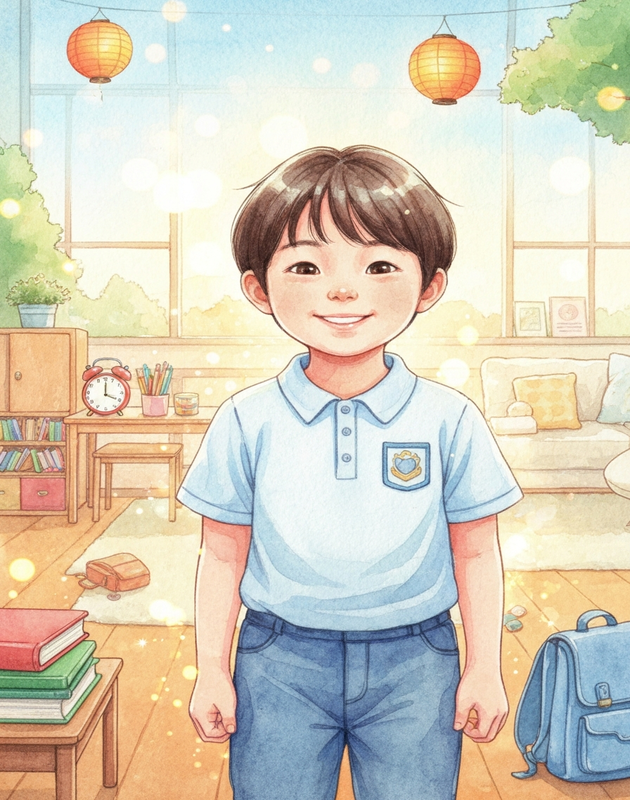


🎉 완료!
📁 파일명: cover_잠꾸러기_지호.png


In [46]:
# 출력 파일명 생성
title = story_data['story_info']['title']
safe_title = "".join([c if c.isalnum() or c in ['_', '-'] else "_" for c in title])
cover_filename = f"cover_{safe_title}.png"

# 표지 이미지 생성 실행
cover_path, cover_image = generate_universal_cover(story_data, cover_filename)

print("\n🎉 완료!")
print(f"📁 파일명: {cover_path}")

## 6단계: JSON에 표지 경로 추가

In [ ]:
# JSON에 표지 이미지 경로 추가
if 'metadata' not in story_data:
    story_data['metadata'] = {}

story_data['metadata']['cover_image'] = cover_filename
if 'version' in story_data['metadata']:
    story_data['metadata']['version'] = story_data['metadata']['version'].replace('v1.0', 'v1.1') + '_with_Imagen4'
else:
    story_data['metadata']['version'] = 'v1.1_with_Imagen4'

# 업데이트된 JSON 저장
updated_json_filename = json_filename.replace('.json', '_with_cover.json')

with open(updated_json_filename, 'w', encoding='utf-8') as f:
    json.dump(story_data, f, ensure_ascii=False, indent=4)

print(f"✅ 업데이트된 JSON 저장 완료: {updated_json_filename}")
print(f"📷 표지 이미지 경로: {story_data['metadata']['cover_image']}")

## 7단계: 파일 다운로드

In [ ]:
# 표지 이미지 다운로드
print("📥 표지 이미지 다운로드 중...")
files.download(cover_filename)

# 업데이트된 JSON 다운로드
print("📥 업데이트된 JSON 다운로드 중...")
files.download(updated_json_filename)

print("\n✅ 모든 파일 다운로드 완료!")

---

## 📝 사용 팁

### 이 노트북의 특징:

1. **자동 분석**: JSON 내용을 자동으로 분석해서 적절한 이미지 생성
2. **텍스트 제거**: 완전히 깨끗한 일러스트만 생성 (제목/글자 없음)
3. **범용성**: 어떤 한국 동화 JSON이든 작동
4. **아동용 강조**: 3-7세 아동 대상 동화책 스타일

### 자동으로 파악되는 요소:

- **주인공 성별**: 소녀/소년 자동 감지
- **시대 배경**: 조선시대/근대/현대 자동 감지
- **분위기**: 모험/신비/따뜻함 자동 감지
- **한국 요소**: 한복, 전통 소품 자동 추출

### 표지에 제목을 추가하고 싶다면:

**권장 방법**: 프론트엔드에서 텍스트 오버레이
```javascript
// React Native 예시
<View style={styles.cover}>
  <Image source={{uri: cover_image_url}} />
  <Text style={styles.title}>{story_title}</Text>
</View>
```

이렇게 하면:
- ✅ 제목 폰트/크기/색상 자유롭게 조정
- ✅ 다국어 지원 가능
- ✅ 이미지는 깨끗하게 재사용 가능
